In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV

from lookahead import Lookahead
import uncert
import pred
import prop

%matplotlib inline
np.set_printoptions(precision=3)

## Loading the wine data

In [2]:
#load data
x,y0 = data = load_wine(return_X_y=True)
scaler = StandardScaler()
scaler.fit(x)
scaler.transform(x, copy=False)
n = x.shape[0]
d = x.shape[1]

## Defining the groundtruth model.
Here we choose Ridge Regression with polynomial features (degree =2) as the groundtruth function f* and
select the best model using 5 - fold cross validation.

In [3]:
class Fstar():
    def __init__(self):
        self.model = RidgeCV(alphas=alpha_range)
    def fit(self, x, y):
        x2 = np.hstack([x, 0.5*x**2]).round(3)
        self.model.fit(x2, y)
    def predict(self, x):
        x2 = np.hstack([x, 0.5*x**2]).round(3)
        return self.model.predict(x2)

In [4]:
# Hyperparamters for the ground truth model
C_range = 2. ** np.arange(-8,10,2)
gamma_range = 2. ** np.arange(-10,3,2)
alpha_range = 2.**np.arange(-8,8)
param_grid = {'gamma':gamma_range, 'C':C_range}

# Train the model
fstar = Fstar()
fstar.fit(x, y0)
y = fstar.predict(x)
mse_star = np.mean(np.square(y-y0))
mae_star = np.mean(np.abs(y-y0))
print("[f*] mse(y,y0):", mse_star)
print("[f*] mae(y,y0):", mae_star)

[f*] mse(y,y0): 0.04106275149850254
[f*] mae(y,y0): 0.16267291869162256


## Visualizing the features.
Features 0,1 have non-linaer relation to y

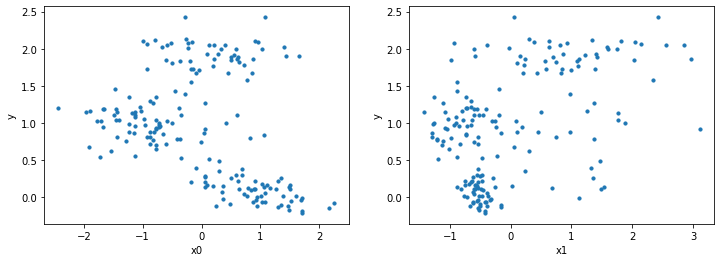

In [5]:
plt.rcParams['figure.figsize'] = (12.0, 4.0)

plt.subplot(121)
plt.scatter(x[:,0], y, s=10)
plt.xlabel('x0')
plt.ylabel('y')

plt.subplot(122)
plt.scatter(x[:,1], y, s=10)
plt.xlabel('x1')
plt.ylabel('y')
plt.show()


# np.corrcoef(x_trn[:,i],y_trn[:])[0,1]

## Generating the train-test splits

In [6]:
# split data
trn_sz = 0.75
seed = 1

active = np.where(np.logical_and(x[:,0]>=-0.2,x[:,1]<=-0.3))[0]

x_active = x[active,:]
y_active = y0[active]
n_active = y_active.shape[0]

x_trn, x_tst, y_trn, y_tst = train_test_split(x_active, y_active, test_size=1-trn_sz, random_state=seed)
n_trn, n_tst = (x_trn.shape[0], x_tst.shape[0])
print('n:', n, ', n_active:', n_active, ", n_trn:", n_trn, ", n_tst:", n_tst)

xs = [x_trn, x_tst, x_active, x]
ys = [y_trn, y_tst, y_active, y]

n: 178 , n_active: 57 , n_trn: 42 , n_tst: 15


## Setting the hyperparamters of the look ahead model

In [7]:
# Step Size
eta = 2. 

# L2 regularization coefficients
alphas = np.hstack([1e-5, 2.**np.arange(-8,6,1)])

# Lookahead regularization coefficient
lams = np.hstack([1e-5, 2.**np.arange(-4,2,1)]) #lookahead penalty coefficients

# Setting features that can by altered using mask
# Features - 0, 1, 4, 5, 7 and 8 are the only non-immutable features
mask = np.zeros(d)
mask[[0,1,4,5,7,8]] = 1

# Number of cycles to train
num_cycles = 10

# Confidence Intervals
z_score = 1.65 # for confiednce intervals (1.28-90%, 1.65=95%)

""" Hyperparameters for Prediction Model"""
# L2 - regularization coeffs
alpha_f = 0.5
# Regularization type (L1/L2)
reg_type = 'l2'
# Learning rate
lr_f = 0.1
# Number of iterations
num_iter_init = 1000 #for initial f
num_iter_f = 100 #for training f in cycles

""" Hyperparameters for Uncertainty Model"""
# Number of bootstrapped models
num_gs = 20 
# Learning rate
lr_g = 0.1
# Number of iterations
num_iter_g = 500 #for training g in cycles

## Training a baseline model and displaying the weights learnt and the result

t: 0
[f] mse: 0.0557, la_reg: 0.0000, norm_reg: 0.0034, obj: 0.0832
[f] improve*: 0.036



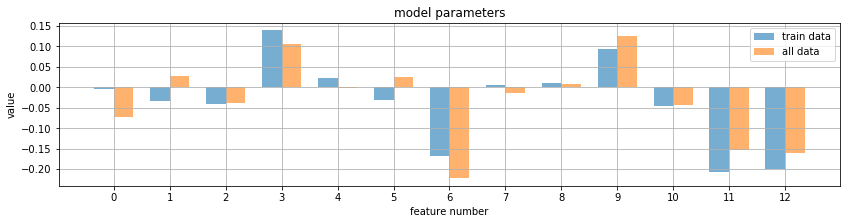

baseline: (skl)
		trn	tst	actv	all
mse	0.0557	0.0511	0.0544	0.0780
mae	0.1932	0.1750	0.1884	0.2229

baseline: (ours)
base:	trn	tst	actv	all
mse	0.0557	0.0511	0.0544	0.0780
mae	0.1932	0.1750	0.1884	0.2229
imprv	0.0358	-0.0323	0.0179	-0.0039

best reg coef: 8.0 , idx: 12


In [8]:
# baselines
verbose = True

# scikitlearn - to get optimal regularization coefficient via CV)
f_base_skl = RidgeCV(alphas=alphas, cv=None).fit(x_trn, y_trn)
w_base_skl = f_base_skl.coef_
best_alpha = float(f_base_skl.alpha_)
best_alpha_idx = int(np.where(alphas==best_alpha)[0])

# benchmark trained on all data
f_bench = RidgeCV(alphas=alphas, cv=None).fit(x, y)
w_bench = f_bench.coef_

# ours - for sanity check (vs SKL) and to get baseline improvement
f_base = pred.PredModel(d, reg_type=reg_type, alpha=best_alpha, lr=lr_f, num_iter_init=num_iter_init)
model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
_, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)

plt.rcParams['figure.figsize'] = (14.0, 3.0)
barWidth = 0.35
plt.bar(np.arange(d)-barWidth/2,w_base_skl/np.sum(np.abs(w_base_skl)),alpha=0.6,width=barWidth)
plt.bar(np.arange(d)+barWidth/2,w_bench/np.sum(np.abs(w_bench)),alpha=0.6,width=barWidth)
plt.xticks(np.arange(d))
plt.title('model parameters')
plt.ylabel('value')
plt.xlabel('feature number')
plt.legend(['train data','all data'])
plt.grid()
plt.show()

perf_base_skl = {'mse':[], 'mae':[]}
for x_,y_ in zip(xs, ys):
    yhat_ = f_base_skl.predict(x_)
    perf_base_skl['mse'].append(np.mean(np.square(y_-yhat_)))
    perf_base_skl['mae'].append(np.mean(np.abs(y_-yhat_)))
print('baseline: (skl)')
print('\t\ttrn\ttst\tactv\tall')
print(('mse'+'\t{:.4f}'*4).format(*perf_base_skl['mse']))
print(('mae'+'\t{:.4f}'*4).format(*perf_base_skl['mae']))
print()

perf_base = {'mse':[], 'mae':[], 'improve':[]}
for x_,y_ in zip(xs, ys):
    perf_base['mse'].append(model_base.mse(x_,y_))
    perf_base['mae'].append(model_base.mae(x_,y_))
    perf_base['improve'].append(model_base.improve(x_,y_,eta,mask))
print('baseline: (ours)')
print('base:\ttrn\ttst\tactv\tall')
print(('mse'+'\t{:.4f}'*4).format(*perf_base['mse']))
print(('mae'+'\t{:.4f}'*4).format(*perf_base['mae']))
print(('imprv'+'\t{:.4f}'*4).format(*perf_base['improve']))
print()

print('best reg coef:', best_alpha, ', idx:', best_alpha_idx)

## Training the lookahead model for different values of lam

In [9]:
# train our model
verbose = True

models = []
mfs = []
mus = []
for lam_ in lams:
    print('-- lam_:', lam_, '--')
    f = pred.PredModel(d, reg_type=reg_type, alpha=alpha_f, lr=lr_f, num_iter=num_iter_f, num_iter_init=num_iter_init)
    u = uncert.BootstrapResid(d, f, alpha=0., num_gs=num_gs, z_score=z_score, lr=lr_g, num_iter=num_iter_g)
    h = prop.PropModel(random_state=seed)

    model = Lookahead(f, u, h, lam=lam_, eta=eta, mask=mask, ground_truth_model=fstar)
    mf, mu = model.train(x_trn, y_trn, num_cycles=num_cycles, random_state=seed, verbose=verbose)
    
    models.append(model)
    mfs.append(mf)
    mus.append(mu)
    
mus = np.asarray(mus)
mfs = np.asarray(mfs)

-- lam_: 1e-05 --
t: 0
[f] mse: 0.0439, la_reg: 0.0000, norm_reg: 0.0086, obj: 0.0482
[f] improve*: 0.051

t: 1
[h] n_eff: 34.90, w_sum: 37.60
[u] loss: 0.0766, norm_reg: 0.0000, obj: 0.0766
[u] size: 0.410, contain*: 0.667
[f] mse: 0.0439, la_reg: 0.1652, norm_reg: 0.0086, obj: 0.0482
[f] improve*: 0.051

t: 2
[h] n_eff: 34.91, w_sum: 37.75
[u] loss: 0.0765, norm_reg: 0.0000, obj: 0.0765
[u] size: 0.410, contain*: 0.667
[f] mse: 0.0438, la_reg: 0.1655, norm_reg: 0.0086, obj: 0.0482
[f] improve*: 0.051

t: 3
[h] n_eff: 34.92, w_sum: 37.84
[u] loss: 0.0764, norm_reg: 0.0000, obj: 0.0764
[u] size: 0.410, contain*: 0.667
[f] mse: 0.0438, la_reg: 0.1656, norm_reg: 0.0086, obj: 0.0482
[f] improve*: 0.051

t: 4
[h] n_eff: 34.93, w_sum: 37.90
[u] loss: 0.0764, norm_reg: 0.0000, obj: 0.0764
[u] size: 0.409, contain*: 0.667
[f] mse: 0.0438, la_reg: 0.1658, norm_reg: 0.0086, obj: 0.0482
[f] improve*: 0.051

t: 5
[h] n_eff: 34.93, w_sum: 37.94
[u] loss: 0.0764, norm_reg: 0.0000, obj: 0.0764
[u] s

[h] n_eff: 25.04, w_sum: 7.66
[u] loss: 0.0717, norm_reg: 0.0000, obj: 0.0717
[u] size: 0.538, contain*: 0.762
[f] mse: 0.0463, la_reg: 0.1174, norm_reg: 0.0147, obj: 0.0830
[f] improve*: 0.071

-- lam_: 0.5 --
t: 0
[f] mse: 0.0439, la_reg: 0.0000, norm_reg: 0.0086, obj: 0.0482
[f] improve*: 0.051

t: 1
[h] n_eff: 34.90, w_sum: 37.60
[u] loss: 0.0766, norm_reg: 0.0000, obj: 0.0766
[u] size: 0.410, contain*: 0.667
[f] mse: 0.0460, la_reg: 0.1238, norm_reg: 0.0134, obj: 0.1146
[f] improve*: 0.078

t: 2
[h] n_eff: 25.27, w_sum: 11.93
[u] loss: 0.0723, norm_reg: 0.0000, obj: 0.0723
[u] size: 0.514, contain*: 0.714
[f] mse: 0.0473, la_reg: 0.1380, norm_reg: 0.0158, obj: 0.1243
[f] improve*: 0.074

t: 3
[h] n_eff: 23.75, w_sum: 10.29
[u] loss: 0.0716, norm_reg: 0.0000, obj: 0.0716
[u] size: 0.545, contain*: 0.690
[f] mse: 0.0496, la_reg: 0.0971, norm_reg: 0.0189, obj: 0.1076
[f] improve*: 0.085

t: 4
[h] n_eff: 26.42, w_sum: 4.64
[u] loss: 0.0744, norm_reg: 0.0000, obj: 0.0744
[u] size: 0.61

# Evaluating the performance of the trained lookahead models

In [10]:
# evaluate

perf_la = {'mse':[], 'mae':[], 'improve':[], 'contain':[], 'size':[]}
for lam, model in zip(lams,models):
    perf_la['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_la['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_la['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])

    xsp = [model.move_points(x_) for x_ in xs]
    perf_la['contain'].append([model.contain(x_)[0] for x_ in [*xsp, x]])
    perf_la['size'].append([model.contain(x_)[1] for x_ in [*xsp, x]])
perf_la = {k:np.asarray(v) for k,v in zip(perf_la.keys(),perf_la.values())}

print('lookahead: eta:', eta)
for i in range(len(lams)):
    print('\n==============================================\n')
    print('lam:', lams[i])
    print('\ttrn\tts\tactv\tall\tf*')
    print(('mse'+'\t{:.4f}'*5).format(*perf_la['mse'][i,:], mse_star))
    print(('mae'+'\t{:.4f}'*5).format(*perf_la['mae'][i,:], mae_star))
    print(('imprv'+'\t{:.4f}'*4).format(*perf_la['improve'][i,:]))
    print()
    print('\ttrn\'\ttst\'\tactv\'\tall\'\tall')
    print(('contn'+'\t{:.3f}'*5).format(*perf_la['contain'][i,:]))
    print(('intrsz'+'\t{:.3f}'*5).format(*perf_la['size'][i,:]))


lookahead: eta: 2.0


lam: 1e-05
	trn	ts	actv	all	f*
mse	0.0438	0.0580	0.0476	0.1046	0.0411
mae	0.1696	0.1794	0.1722	0.2532	0.1627
imprv	0.0507	-0.0148	0.0335	0.0078

	trn'	tst'	actv'	all'	all
contn	0.667	0.800	0.702	0.556	0.517
intrsz	0.409	0.460	0.423	0.696	0.698


lam: 0.0625
	trn	ts	actv	all	f*
mse	0.0439	0.0531	0.0463	0.2150	0.0411
mae	0.1709	0.1703	0.1707	0.3610	0.1627
imprv	0.0557	-0.0093	0.0386	0.0110

	trn'	tst'	actv'	all'	all
contn	0.690	0.733	0.702	0.528	0.466
intrsz	0.448	0.511	0.465	0.700	0.720


lam: 0.125
	trn	ts	actv	all	f*
mse	0.0444	0.0504	0.0460	0.3244	0.0411
mae	0.1717	0.1641	0.1697	0.4367	0.1627
imprv	0.0603	-0.0043	0.0433	0.0145

	trn'	tst'	actv'	all'	all
contn	0.714	0.800	0.737	0.539	0.478
intrsz	0.477	0.550	0.496	0.709	0.736


lam: 0.25
	trn	ts	actv	all	f*
mse	0.0463	0.0476	0.0466	0.5584	0.0411
mae	0.1740	0.1641	0.1714	0.5626	0.1627
imprv	0.0710	0.0076	0.0543	0.0234

	trn'	tst'	actv'	all'	all
contn	0.762	0.800	0.772	0.590	0.461
intrsz	0.538	0.618	0.559	0.727	0.7

## Training the baseline model for different values of l2 - regularizer coefficient

In [11]:
verbose = False

models_base = []
for alpha in alphas:
    f_base = pred.PredModel(d, reg_type=reg_type, alpha=alpha, lr=lr_f, num_iter_init=num_iter_init)
    model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
    _, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)
    models_base.append(model_base)

perf_base = {'mse':[], 'mae':[], 'improve':[]} #, 'contain':[], 'size':[]}
for model in models_base:
    perf_base['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_base['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_base['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
perf_base = {k:np.asarray(v) for k,v in zip(perf_base.keys(),perf_base.values())}    

# Comparing the performance of lookahead regularizer vs the l2- regularizer
We compare the performace of our lookahead model for various values of lam
with the performance of the baseline model for various values of the l2-regularizer coefficient

seed: 1 , eta: 2.0


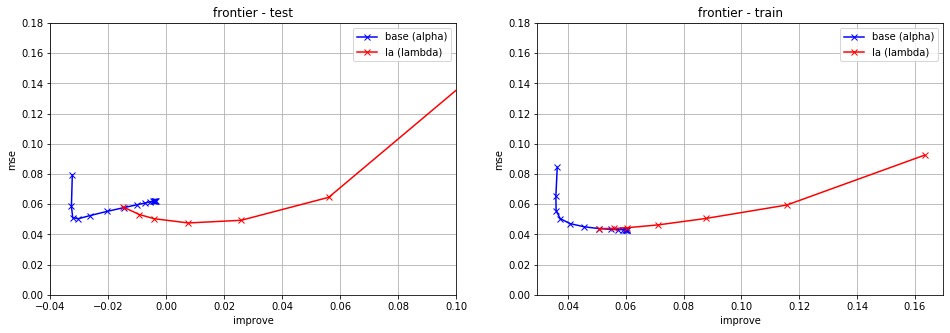

In [12]:
SAVE_FIG = False
fname = 'wine_mask_la+l2'

print('seed:',seed,', eta:',eta)

plt.rcParams['figure.figsize'] = (16.0, 5.0)
plt.subplot(121)
plt.plot(perf_base['improve'][:,1], perf_base['mse'][:,1],'b-x')
plt.plot(perf_la['improve'][:,1], perf_la['mse'][:,1],'r-x')
# plt.plot(perf_naive['improve'][:,1], perf_naive['mse'][:,1],'g-x')
plt.title('frontier - test')
plt.ylabel('mse')
plt.xlabel('improve')
plt.legend(['base (alpha)','la (lambda)','naive (step size)'])
plt.grid()
plt.ylim([0.,0.18])
plt.xlim([-0.04,0.1])

plt.subplot(122)
plt.plot(perf_base['improve'][:,0], perf_base['mse'][:,0],'b-x')
plt.plot(perf_la['improve'][:,0], perf_la['mse'][:,0],'r-x')
# plt.plot(perf_naive['improve'][:,0], perf_naive['mse'][:,0],'g-x')
plt.title('frontier - train')
plt.ylabel('mse')
plt.xlabel('improve')
plt.legend(['base (alpha)','la (lambda)','naive (step size)'])
plt.grid()
plt.ylim([0.,0.18])

if SAVE_FIG:
    plt.draw()
    plt.savefig(fname+'.eps', format='eps')
    plt.savefig(fname+'.png', format='png', dpi=300)
    print('saved ' + fname)
else:
    plt.show()

## Effect of varying the lookahead regularizer coefficient
This plot shows how weights learned vary with increase in lam

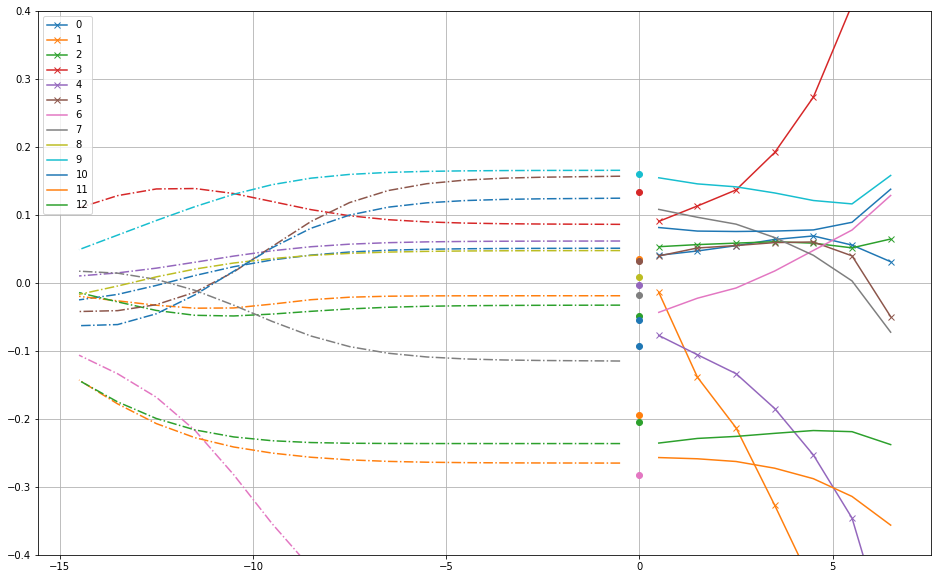

In [13]:
ws_la = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in models])
ws_base = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in models_base])

mask_idx = np.where(mask>0)[0]
non_mask_idx = np.setdiff1d(np.arange(d), mask_idx)

plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.plot(np.arange(len(lams))+0.5,ws_la[:,mask_idx],'x-')
plt.plot(np.arange(len(lams))+0.5,ws_la[:,non_mask_idx],'-')
plt.gca().set_prop_cycle(None)
for i in range(len(w_bench)):
    plt.plot(0,w_bench[i],'o')
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(0,-len(alphas),-1)-0.5,ws_base,'-.')
plt.legend([str(i) for i in range(d)])
plt.grid()
plt.ylim([-0.4,0.4])
plt.show()

This plot shows how coverage rate and interval size vary with increasing lam

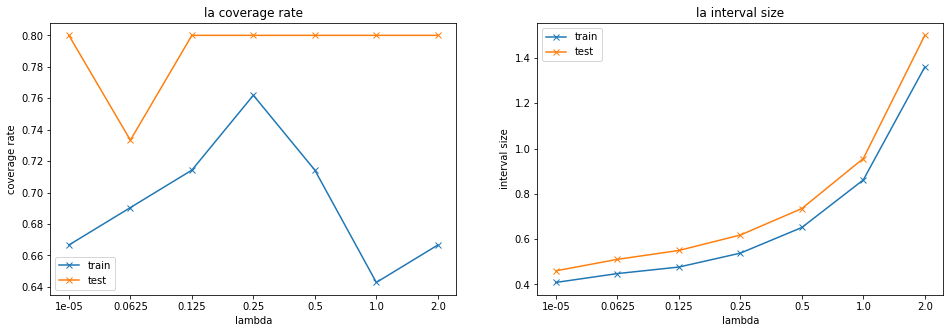

In [14]:
plt.rcParams['figure.figsize'] = (16.0, 5.0)

plt.subplot(121)
plt.plot(np.arange(len(lams)), perf_la['contain'][:,:2],'x-')
plt.title('la coverage rate')
plt.ylabel('coverage rate')
plt.xlabel('lambda')
plt.xticks(np.arange(len(lams)),lams)
plt.legend(['train','test'])

plt.subplot(122)
plt.plot(np.arange(len(lams)), perf_la['size'][:,:2],'x-')
plt.title('la interval size')
plt.ylabel('interval size')
plt.xlabel('lambda')
plt.xticks(np.arange(len(lams)),lams)
plt.legend(['train','test'])
plt.show()